# Evaluation of trained network for temporal super-resolution

In [1]:
#%matplotlib notebook
import ipywidgets as widgets
from ipywidgets import HBox, VBox
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
from IPython.display import display
from utils.evaluate_utils import *
import pandas as pd
from collections import defaultdict
plt.rcParams['figure.figsize'] = [10, 8]
%matplotlib inline

In [2]:
df = pd.read_csv('../results/Overview_models.csv')
df1 = df[['Name', 'notes']]
# display(df1)
pd.set_option("max_colwidth", None)
display(df1)

,Name,notes
0,Temporal4DFlowNet_20230210-0333,NaN
1,Temporal4DFlowNet_20230215-1029,NaN
2,Temporal4DFlowNet_20230217-0602,NaN
3,Temporal4DFlowNet_20230220-0908,NaN
4,Temporal4DFlowNet_20230301-1127,First training on radial sampled data
5,Temporal4DFlowNet_20230301-1641,Basecheck with adapted network code and higher batch size of 32. (Resnet)
6,Temporal4DFlowNet_20230301-1654,First training with densenet blocks (Densenet)
7,Temporal4DFlowNet_20230301-1704,First training with cspnet blocks (CSPnet)
8,Temporal4DFlowNet_20230305-1001,Less depth: 4 -2
9,Temporal4DFlowNet_20230305-1002,Depth change (balance between high lowres blocks): 6 - 6


In [3]:
model_names  = ['20230301-1641', '20230301-1654', '20230301-1704', '20230305-1001', '20230305-1002', '20230305-1008', '20230305-1107'     , '20230306-1120']
tabular_names =['ResNet_8_4'   , 'DenseNet_8_4' , 'CSPNet_8_4'   , 'ResNet_4_2'   ,'ResNet_6_6'    , 'ResNet_4_8'   , 'ResNet_Conv3DT_8_4', 'ResNet_NN_8_4']

### Set model and dataset to evaluate


In [4]:
# Define directories and filenames

model_name = '20230301-1641'#'20230308-1226' #'#'20230308-1226' #'20230301-1641'  '20230301-1654', '20230301-1704'
set_name = 'Test'               
data_model= '4'
step = 2

use_dynamical_mask = False
name_tabular = ' ' # Name the network should have in tabular

### Set evaluation files to compare relative error to


In [5]:
vel_colnames=['u', 'v', 'w']
vel_colnames_fluid = ['u_fluid', 'v_fluid', 'w_fluid']

def load_data(model_name, set_name, data_model, step,dynamic_mask_used, ending_file= ''):
    #directories
    gt_dir = '../data/CARDIAC'
    result_dir = f'../results/Temporal4DFlowNet_{model_name}'
    eval_dir = f'{result_dir}/plots'
    lr_dir = '../data/CARDIAC'

    inbetween_string = ''
    if dynamic_mask_used:
        inbetween_string = '_dynamic'

    #filenames
    gt_filename = f'M{data_model}_2mm_step{step}_static{inbetween_string}.h5'
    lr_filename = f'M{data_model}_2mm_step{step}_static{inbetween_string}_noise.h5'
    result_filename = f'{set_name}set_result_model{data_model}_2mm_step{step}_{model_name[-4::]}_temporal{ending_file}.h5' #_newpadding
    evaluation_filename = f'eval_rel_err_{data_model}_2mm_step{step}_{model_name[-4::]}_temporal.h5'

    print(gt_filename, lr_filename)

    if not os.path.isdir(eval_dir):
        os.makedirs(eval_dir)

    #Params for evalation
    save_relative_error_file= False

    # Setting up
    gt_filepath = '{}/{}'.format(gt_dir, gt_filename)
    res_filepath = '{}/{}'.format(result_dir, result_filename)
    lr_filepath = '{}/{}'.format(lr_dir, lr_filename)
    

    if save_relative_error_file:
        assert(not os.path.exists(f'{result_dir}/{evaluation_filename}')) #STOP if relative error file is already created

    
    gt = {}
    lr = {}
    pred = {}

    with h5py.File(res_filepath, mode = 'r' ) as h_pred:
        with h5py.File(gt_filepath, mode = 'r' ) as h_gt:
            with h5py.File(lr_filepath, mode = 'r' ) as h_lr:
                
                gt["mask"] = np.asarray(h_gt["mask"]).squeeze()
                gt["mask"][np.where(gt["mask"] !=0)] = 1
                if len(gt['mask'].shape) == 4 : # check for dynamical mask, otherwise create one
                    temporal_mask = gt['mask'].copy()
                else:
                    print('Create static temporal mask for model')
                    temporal_mask = create_temporal_mask(gt["mask"], h_gt['u'].shape[0])
                # adapt dimension
                for vel in vel_colnames:
                    
                    gt[vel] = np.asarray(h_gt[vel])
                    pred[vel] = np.asarray(h_pred[f'{vel}_combined'])   # TODO chnaged this with new combination of all axis 
                    lr[vel] = np.asarray(h_lr[vel])[::2, :, :, :]       #TODO: this chnaged with the new loading modules
                    #transpose for temporal resolution
                    # pred[vel] = pred[vel].transpose(1, 0, 2, 3) #TODO changed for new csv file
                    # print(pred[vel].shape)

                    # add information considering only the fluid regions  
                    pred[f'{vel}_fluid'] =np.multiply(pred[vel], temporal_mask)
                    lr[f'{vel}_fluid'] =  np.multiply(lr[vel], temporal_mask[::2, :, :, :])
                    gt[f'{vel}_fluid'] =  np.multiply(gt[vel], temporal_mask)

                    
                #include speed calculations
                gt['speed']   = np.sqrt(gt["u"]**2 + gt["v"]**2 + gt["w"]**2)
                lr['speed']   = np.sqrt(lr["u"]**2 + lr["v"]**2 + lr["w"]**2)
                pred['speed'] = np.sqrt(pred["u"]**2 + pred["v"]**2 + pred["w"]**2)


    return lr, gt, pred, temporal_mask, eval_dir

def load_interpolation(data_model, step, lr, gt, use_dynamical_mask):
    
    interpolate_NN = {}
    interpolate_linear = {}
    interpolate_cubic = {}

    inbetween_string = ''
    if use_dynamical_mask:
        inbetween_string = '_dynamic'

    lr_filename = f'M{data_model}_2mm_step{step}_static{inbetween_string}_noise.h5'


    interpolation_file= f'../results/interpolation/{lr_filename[:-3]}_interpolation'
    if not os.path.isfile(interpolation_file):
        print("Interpolation file does not exist - calculate interpolation and save files")
        print("Save interpolation files to: ", interpolation_file)
        
        #this can take a while
        for vel in vel_colnames:
            print("Interpolate low resolution images - ", vel)
            print(gt['mask'].shape)
            interpolate_linear[vel] = temporal_linear_interpolation(lr[vel], gt[vel].shape)
            interpolate_linear[f'{vel}_fluid'] = np.multiply(interpolate_linear[vel], gt['mask'])

            interpolate_cubic[vel] = temporal_cubic_interpolation(lr[vel], gt[vel].shape)
            interpolate_cubic[f'{vel}_fluid'] = np.multiply(interpolate_cubic[vel], gt['mask'])

            interpolate_NN[vel] = temporal_NN_interpolation(lr[vel], gt[vel].shape)
            interpolate_NN[f'{vel}_fluid'] = np.multiply(interpolate_NN[vel], gt['mask'])

            prediction_utils.save_to_h5(interpolation_file, f'linear_{vel}' , interpolate_linear[vel], compression='gzip')
            prediction_utils.save_to_h5(interpolation_file, f'cubic_{vel}' , interpolate_cubic[vel], compression='gzip')
            prediction_utils.save_to_h5(interpolation_file, f'NN_{vel}' , interpolate_NN[vel], compression='gzip')
    else:
        print("Load existing interpolation file")
        with h5py.File(interpolation_file, mode = 'r' ) as h_interpolate:
            for vel in vel_colnames:
                interpolate_linear[vel] = np.array(h_interpolate[f'linear_{vel}'])
                interpolate_cubic[vel] =  np.array(h_interpolate[f'cubic_{vel}'])
                interpolate_NN[vel] =     np.array(h_interpolate[f'NN_{vel}'])


                interpolate_linear[f'{vel}_fluid'] = np.multiply(interpolate_linear[vel], gt['mask'])
                interpolate_cubic[f'{vel}_fluid'] = np.multiply(interpolate_cubic[vel], gt['mask'])
                interpolate_NN[f'{vel}_fluid'] = np.multiply(interpolate_NN[vel], gt['mask'])

    return interpolate_linear, interpolate_cubic, interpolate_NN

lr, gt, pred, temporal_mask, eval_dir = load_data(model_name, set_name, data_model, step, use_dynamical_mask)
interpolate_linear, interpolate_cubic, interpolate_NN = load_interpolation(data_model, step,lr, gt, use_dynamical_mask)

M4_2mm_step2_static.h5 M4_2mm_step2_static_noise.h5
Create static temporal mask for model
Create static temporal mask.
Load existing interpolation file


### Tabulate plots

In [ ]:
def get_evaluation_metrics(results, prediction, ground_truth, t_peak_flow):
    results['RMSEx'].append(calculate_rmse(prediction['u_fluid'], ground_truth['u_fluid'], ground_truth['mask'])[t_peak_flow])
    results['RMSEy'].append(calculate_rmse(prediction['v_fluid'], ground_truth['v_fluid'], ground_truth['mask'])[t_peak_flow])
    results['RMSEz'].append(calculate_rmse(prediction['w_fluid'], ground_truth['w_fluid'], ground_truth['mask'])[t_peak_flow])
    kx, R2_x = calculate_k_R2(prediction['u'][t_peak_flow], ground_truth['u'][t_peak_flow], temporal_mask[t_peak_flow])
    ky, R2_y = calculate_k_R2(prediction['v'][t_peak_flow], ground_truth['v'][t_peak_flow], temporal_mask[t_peak_flow])
    kz, R2_z = calculate_k_R2(prediction['w'][t_peak_flow], ground_truth['w'][t_peak_flow], temporal_mask[t_peak_flow])
    results['kx'].append(kx)
    results['ky'].append(ky)
    results['kz'].append(kz)
    results['R_2x'].append(R2_x)
    results['R_2y'].append(R2_y) 
    results['R_2z'].append(R2_z) 
    results['RE'].append(calculate_relative_error_normalized(prediction["u"], prediction["v"], prediction["w"], ground_truth["u"], ground_truth["v"] , ground_truth["w"], ground_truth["mask"])[t_peak_flow])

    return results

In [ ]:
# model_names  = ['20230301-1641' ]
# tabular_names = []
set_name = 'Test'               
data_model= '4'
step = 2
dict_results = defaultdict(list)#{ 'Name', 'RMSEx', 'RMSEy', 'RMSEz', 'k','k_bounds',  'R_2','R_bounds', 'RE', 'RE_bounds'}
peak_flow_frame = np.unravel_index(np.argmax(gt['speed']), shape = gt['speed'].shape)[0]
print("Peak flow frame:", peak_flow_frame)

for m_name, t_name in zip(model_names, tabular_names):
    #load data
    _, gt_1, prediction_1,_, _ = load_data(m_name, set_name, data_model, step, dynamic_mask_used = False)
    dict_results['Network'].append(t_name)
    dict_results = get_evaluation_metrics(dict_results,prediction_1,gt_1, peak_flow_frame)

In [ ]:
dict_results['Network'].append('Linear interpolation')
dict_results = get_evaluation_metrics(dict_results,interpolate_linear,gt, peak_flow_frame)

dict_results['Network'].append('Cubic interpolation')
dict_results = get_evaluation_metrics(dict_results,interpolate_cubic,gt, peak_flow_frame)


r_dt = pd.DataFrame(dict_results).round(4)
display(r_dt)


In [ ]:
print(r_dt.to_latex(index=False))

### Calculate relative error and mean speed

In [6]:
rel_error =calculate_relative_error_normalized(pred["u"], pred["v"], pred["w"], gt["u"], gt["v"] , gt["w"], gt["mask"])
error_pointwise, error_absolut = calculate_pointwise_error(pred["u"], pred["v"], pred["w"], gt["u"], gt["v"] , gt["w"], gt["mask"])
rel_error_lin_interpolation =   calculate_relative_error_normalized(interpolate_linear["u"], interpolate_linear["v"], interpolate_linear["w"], gt["u"], gt["v"] , gt["w"], gt["mask"])
rel_error_cubic_interpolation = calculate_relative_error_normalized(interpolate_cubic["u"], interpolate_cubic["v"], interpolate_cubic["w"], gt["u"], gt["v"] , gt["w"], gt["mask"])

for vel in vel_colnames:
    error_absolut[f'{vel}_fluid'] = np.multiply(error_absolut[vel], gt["mask"])

# mean speed of gt and prediction
gt['mean_speed'] = calculate_mean_speed(gt["u_fluid"], gt["v_fluid"] , gt["w_fluid"], gt["mask"])
pred['mean_speed'] = calculate_mean_speed(pred["u_fluid"], pred["v_fluid"] , pred["w_fluid"], gt["mask"])
interpolate_linear['mean_speed'] = calculate_mean_speed(interpolate_linear["u_fluid"], interpolate_linear["v_fluid"] ,interpolate_linear["w_fluid"], gt["mask"])
interpolate_cubic['mean_speed'] = calculate_mean_speed(interpolate_cubic["u_fluid"], interpolate_cubic["v_fluid"] , interpolate_cubic["w_fluid"], gt["mask"])

Create static temporal mask.
max/min before tanh 52297.324 0.0
max/min after tanh 1.0 0.0


2023-03-10 10:25:29.796509: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-10 10:25:29.796905: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-10 10:25:29.834641: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-10 10:25:29.835041: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-10 10:25:29.835365: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

Create static temporal mask.
Create static temporal mask.
max/min before tanh 346410.16 0.0
max/min after tanh 1.0 0.0
Create static temporal mask.
max/min before tanh 1348533.0 0.0
max/min after tanh 1.0 0.0
Create static temporal mask.
Create static temporal mask.
Create static temporal mask.
Create static temporal mask.


In [7]:
vel_colnames = ['u', 'v', 'w']
min_v = {}
max_v = {}
for vel in vel_colnames:
    min_v[vel] = np.quantile(gt[vel][np.where(temporal_mask !=0)].flatten(), 0.01)
    max_v[vel] = np.quantile(gt[vel][np.where(temporal_mask !=0)].flatten(), 0.99)

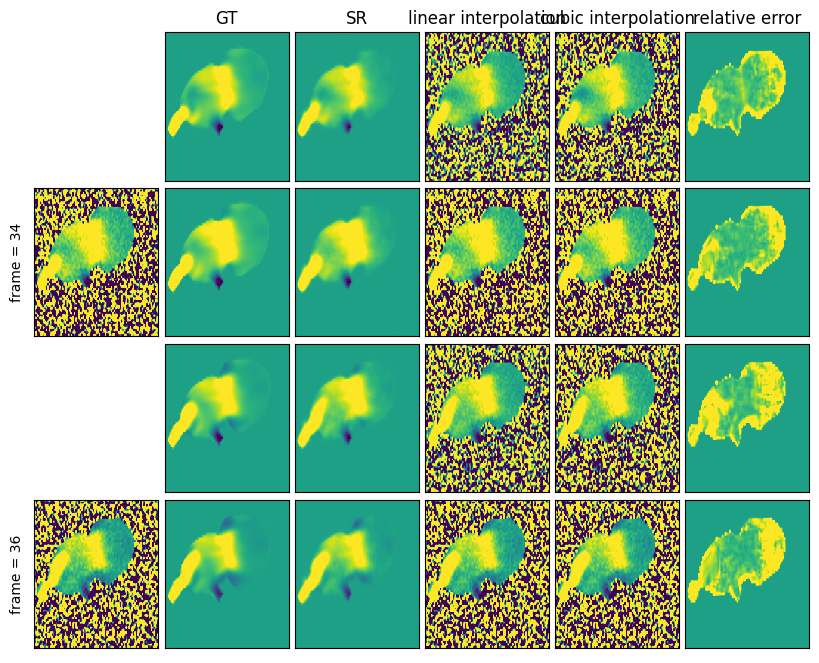

In [8]:
# plot_comparison_temporal(, ,  frame_idx = peak_flow_frame, axis = 1, slice_idx = 40, )


## Compare multiple models in the same set

In [ ]:
def comparison_multiple_models(model_names, set_names, labels, colors,name_base_net, name_comparison):
    frames = len(rel_error)
    vel_colnames=['u', 'v', 'w']

    #plot
    plt.subplot(3, 1, 1)
    plt.title("Relative error")
    plt.plot(rel_error, label = f'{name_base_net}_{set_name}')
    plt.plot(rel_error_lin_interpolation[:-1], label = 'linear interpolation',color = 'yellowgreen')
    plt.plot(rel_error_cubic_interpolation, label = 'cubic interpolation', color = 'forestgreen')
    plt.plot(50*np.ones(len(rel_error)), 'k:')
    plt.xlabel("Frame")
    plt.ylabel("Relative error (%)")
    plt.ylim((0, 50))
    # points_in_mask = np.where(temporal_mask !=0)

    # reshaped_error = np.tanh(error_pointwise[:, points_in_mask[1], points_in_mask[2], points_in_mask[3]].reshape(frames, -1))
    # max_error = np.max(reshaped_error, axis=1)*100

    # sd_error = np.std(reshaped_error, axis = 1)*100
    # error = np.random.normal(0, sd_error, size=len(rel_error))
    # # plt.fill_between(range(len(rel_error)), rel_error-sd_error, rel_error+sd_error, alpha = 0.5)

    plt.subplot(3, 1, 2)
    plt.plot(calculate_rmse(pred['speed'], gt['speed'], gt['mask']), label = f'{name_base_net}_{set_name}')
    plt.ylabel('RMSE')
    plt.xlabel('Frame')
    plt.title('RMSE')

    plt.subplot(3, 1, 3)
    plt.plot(gt['mean_speed'], label ='Ground truth',color = 'black')
    plt.plot(pred['mean_speed'],'b', label= f'{name_base_net}_{set_name}', color = 'steelblue')
    # plt.plot(interpolate_linear['mean_speed'][:-1], label = 'linear interpolatiom', color = 'yellowgreen')
    # plt.plot(interpolate_cubic['mean_speed'][:-1] , label = 'cubic interpoaltion', color = 'forestgreen')
    plt.xlabel("Frame")
    plt.ylabel("Mean speed (cm/s)")
    plt.legend()

    #TODO delete later
    peak_flow = []
    for m_name, s_name, label, color in zip(model_names, set_names, labels, colors):
        lr_1, gt_1, prediction_1,temporal_mask_1, _ = load_data(m_name, s_name, data_model, step, dynamic_mask_used = False)
        print("Here we assume that we have a static mask, please change later")
        rel_err = calculate_relative_error_normalized(prediction_1["u"], prediction_1["v"], prediction_1["w"], gt_1["u"], gt_1["v"] , gt_1["w"], gt_1["mask"])
        # pointwise_error, _  = calculate_pointwise_error(prediction_1["u"], prediction_1["v"], prediction_1["w"], gt_1["u"], gt_1["v"] , gt_1["w"], gt_1["mask"])
        # interpolate_linear_1, interpolate_cubic_1, interpolate_NN_1 = load_interpolation(data_model, step, lr_1, gt_1, use_dynamical_mask = False)
        # rel_error_lin_interpolation_1 =   calculate_relative_error_normalized(interpolate_linear_1["u"], interpolate_linear_1["v"], interpolate_linear_1["w"], gt_1["u"], gt_1["v"] , gt_1["w"], gt_1["mask"])
        # rel_error_cubic_interpolation_1 = calculate_relative_error_normalized(interpolate_cubic_1["u"], interpolate_cubic_1["v"], interpolate_cubic_1["w"], gt_1["u"], gt_1["v"] , gt_1["w"], gt_1["mask"]) 
        
        # reshaped_error = np.tanh(pointwise_error[:, points_in_mask[0], points_in_mask[1], points_in_mask[2]].reshape(frames, -1))
        # max_error = np.max(reshaped_error, axis=1)*100

        # sd_error = np.std(reshaped_error, axis = 1)*100
        # error = np.random.normal(0, sd_error, size=len(rel_error))
        # if m_name != '20230301-1704':
        plt.subplot(3, 1, 1)
        # plt.fill_between(range(len(rel_error)), rel_err-sd_error, rel_err+sd_error, alpha = 0.5)
        plt.plot(rel_err, label=label, color= color)
        # plt.plot(rel_error_lin_interpolation_1[:-1],'--', label = f'linear interpolation {label}',color = 'yellowgreen')
        # plt.plot(rel_error_cubic_interpolation_1,'--',  label = f'cubic interpolation {label}', color = 'forestgreen')
        plt.legend()
        
        plt.subplot(3, 1, 2)
        plt.plot(calculate_rmse(prediction_1['speed'], gt_1['speed'], gt_1['mask']), label = f'{label}_speed', color= color)
        plt.legend()

        plt.subplot(3, 1, 3)
        plt.plot(calculate_mean_speed(prediction_1["u_fluid"], prediction_1["v_fluid"], prediction_1["w_fluid"],gt_1["mask"]), label = label, color= color)
        # plt.plot(calculate_mean_speed(gt_1["u_fluid"], gt_1["v_fluid"], gt_1["w_fluid"],gt_1["mask"]),'--', label = f'gt_{label}', color= 'black')

    plt.legend()
    plt.tight_layout()
    plt.savefig(f'../results/plots/ComparisonPlots/Error_comparison_{name_comparison}.svg')
    plt.show()

### Comparison depth resnet

In [ ]:
model_names = ['20230305-1001', '20230305-1002', '20230305-1008'] # resnet: Temporal4DFlowNet_20230301-1641 #
set_names = [set_name for _ in range(len(model_names))]
labels = [f'ResNet_4-2_{set_names[0]}', f'ResNet_6-6_{set_names[0]}', f'ResNet_4-8_{set_names[0]}']
colors = ['darkorange', 'brown', 'orchid', 'darkviolet']
name_comparison = 'Depth'
name_base_net = 'ResNet-Default-8-4'

comparison_multiple_models(model_names, set_names, labels, colors,name_base_net, name_comparison)


### Comparison sampling of data

In [ ]:
model_names = ['20230301-1127'] 
set_names = [set_name for _ in range(len(model_names))]
labels = [f'ResNet_RadialSampling_{set_names[0]}']
colors = ['darkorange', 'brown', 'orchid', 'darkviolet'] 
name_comparison = 'RadialSampling'
name_base_net = 'ResNet_CartesianSampling'

comparison_multiple_models(model_names, set_names, labels, colors,name_base_net, name_comparison)

### Comparison Upsampling layer

In [ ]:
model_names = ['20230305-1107', '20230306-1120']# resnet: Temporal4DFlowNet_20230301-1641 #
set_names = [set_name for _ in range(len(model_names))]
labels = [f'TransposedConv3D_{set_names[0]}', f'Upsampling3D_NN_{set_names[1]}']
colors = ['darkorange', 'brown', 'orchid', 'darkviolet'] 
name_comparison = 'upsampling'
name_base_net = 'bilinear upsampling'

comparison_multiple_models(model_names, set_names, labels, colors,name_base_net, name_comparison)

### Comparison architecture

In [ ]:
model_names = ['20230301-1654', '20230301-1704'] ## resnet: Temporal4DFlowNet_20230301-1641 #
set_names = [set_name for _ in range(len(model_names))]
labels = [f'DenseNet_{set_names[0]}', f'CSPNet_{set_names[0]}']
colors = ['darkorange', 'brown', 'orchid', 'darkviolet']
name_comparison = 'Architecture'
name_base_net = 'ResNet'
comparison_multiple_models(model_names, set_names, labels, colors,name_base_net, name_comparison)

Compare dynamic and static mask

In [ ]:
model_names = ['20230301-1641' ] ## resnet: Temporal4DFlowNet_20230301-1641 #
set_names = [set_name for _ in range(len(model_names))]
labels = [f'Static_{set_names[0]}', f'C{model_names[0][-4:]}_{set_names[0]}']
colors = ['darkorange', 'brown', 'orchid', 'darkviolet']
name_comparison = 'Static_dynamic_mask'
name_base_net = 'Dynamic mask'
comparison_multiple_models(model_names, set_names, labels, colors,name_base_net, name_comparison)

